In [1]:
from core.trade_service.traders.MA_Trader import MA_Trader
from core.analitics.basic_plots import to_pandas
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

Hipotesis:  
Cuando la caida es pronunciada, comprar en el diferencial cero de la Short

In [3]:
def pendiente(data, period_init, perdio_end):
    assert period_init < perdio_end < 0, 'Periord should be lower than zero'
    if len(data) >= -period_init+1:
        return (data[perdio_end] - data[period_init]) / data[period_init] 
    else:
        return 0.

In [4]:
def pendiente(data, period_init, perdio_end):
    assert period_init < perdio_end < 0, 'Periord should be lower than zero'
    if len(data) >= -period_init+1:
        return (data[perdio_end] - data[period_init]) / (perdio_end - period_init)
    else:
        return 0.

In [99]:
from core.utils.time_utils import seconds_to_next_event, get_minutes_from_interval
class MA_Trader2(MA_Trader):
    def __init__(self,
                 mode='test',
                 symbol='BTCUSDT',
                 interval_source='5m',
                 interval_group='1h',
                 on_investment: bool = False,
                 column_name: str = 'close',
                 period_short: int = 3,
                 period_long: int = 10,
                 panic=-0.01,
                 start_time=datetime.fromisoformat('2020-01-01 00:00:00'),
                 slope_long = -20,
                 slope_short = -5,
                 size_first_window = 5,
                 gap_btw_windows = 2,
                 size_second_window = 3
             ):
        super().__init__( 
                        mode,
                        symbol,
                        interval_source,
                        interval_group,
                        on_investment,
                        column_name,
                        period_short,
                        period_long,
                        panic,
                        start_time)
        self.slope_long = slope_long
        self.slope_short = slope_short
        self.size_first_window = size_first_window
        self.gap_btw_windows = gap_btw_windows
        self.size_second_window = size_second_window
    
    def _calc_window_limits(self, size_first_window, gap_btw_windows, size_second_window):
        return -size_first_window-gap_btw_windows-size_second_window, -gap_btw_windows-size_second_window, -size_second_window, -1
    
    def evaluate_buy(self, data):
        if len(data) > self.period_long:
            ma_short_data = self.ma_short.evaluate(data)
            l1, l2, l3, l4 = self._calc_window_limits(self.size_first_window, self.gap_btw_windows, self.size_second_window)
            if not self.jump_cycle and pendiente(ma_short_data, l1, l2) < self.slope_long and pendiente(ma_short_data, l3, l4) > self.slope_short:
                    self.jump_cycle = True
                    return True
            if ma_short_data[-1] > self.ma_long.evaluate(data)[-1]:
                self.jump_cycle = False
                return True
            else:
                return False
        else:
            return False

    def evaluate_sell(self, data):
        # evaluate panic
        buy_price = self.trade_record[np.max(list(self.trade_record.keys()))]['start_price']
        current_price = data.close.values[-1]
        gain = (current_price - buy_price) / buy_price
        if gain < self.panic:
            return True
        else:
            return self.ma_short.evaluate(data)[-1] < self.ma_long.evaluate(data)[-1]
        
    def evaluate(self, percentage_trade=1):
        self.jump_cycle = False
        logging.info('trade evaluate: Start Evaluation')
        while not self.data_mgr.end_data:
            data = self.get_data()
            if self.on_investment:
                if self.jump_cycle:
                    self.evaluate_buy(data)
                else:
                    if self.evaluate_sell(data):
                        self.con.sell()
                        self.on_investment = False
                        self.trace('sell', data)
                    else:
                        logging.info('trade evaluation: Selling Evaluation = False')
            else:
                if self.evaluate_buy(data):
                    self.con.buy(percentage_trade=percentage_trade)
                    self.on_investment = True
                    self.trace('buy', data)
                else:
                    logging.info('trade evaluation: Buying Evaluation: False')
            if self.mode in ['test', 'PROD']:
                self.wait(seconds_to_next_event(self.interval_source, 20) / 60)
            else:
                self.update_current_time_(get_minutes_from_interval(self.interval_source))


In [100]:
model2 = MA_Trader2(mode='sim',
                  period_long=25, 
                  period_short=14,
                 panic= -0.04,
                 interval_group='1h', 
                 interval_source='1h',
                 start_time=datetime.fromisoformat('2020-01-01'),
                 slope_long=-18.78,
                 slope_short=-8.33,
                 size_first_window=5,
                 gap_btw_windows=2,
                 size_second_window=3
                 )
model2.evaluate()
model2.score(1,1)

123.20210291452464

In [48]:
model = MA_Trader(mode='sim',
                  period_long=25, 
                  period_short=14,
                 panic= -0.04,
                 interval_group='1h', 
                 interval_source='1h',
                 start_time=datetime.fromisoformat('2020-01-01')
                 )
model.evaluate()
model.score(1,1)

115.49274773163124

In [33]:

def plot_pendiente(model, period_init, period_end):
    pend = []
    data = model.data_mgr.get_data()
    data.loc[:, 'mashort'] = model.ma_short.evaluate(data)
    data = data[data.index.month == 6]
    y = data.mashort.to_list()
    for i in range(len(y)):
        y_part = y[:i]
        pend.append(pendiente(y_part, period_init, period_end))
    plt.plot(pend)

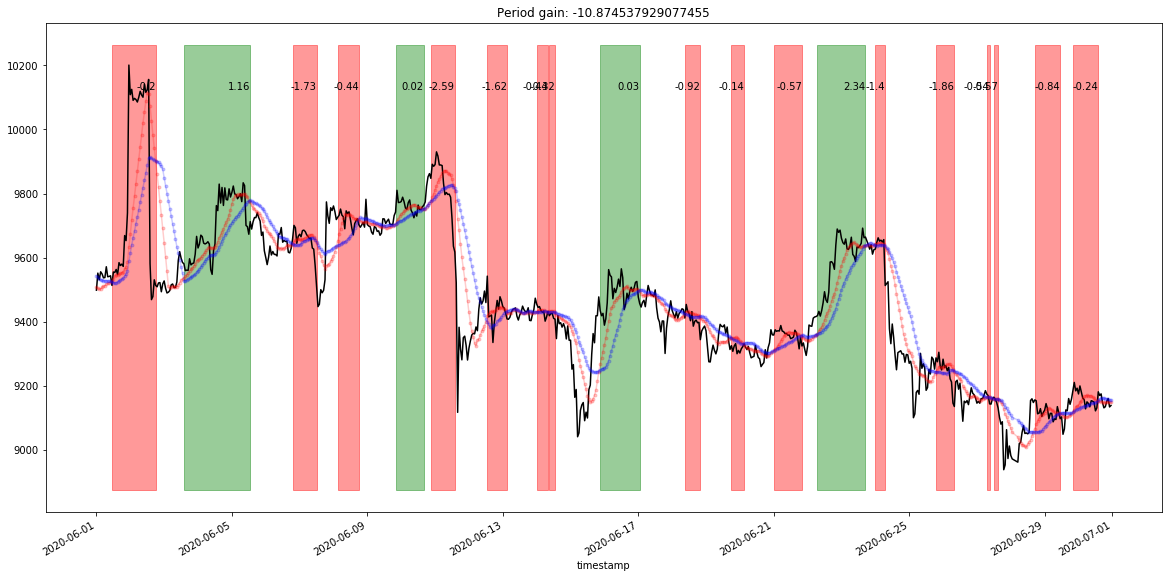

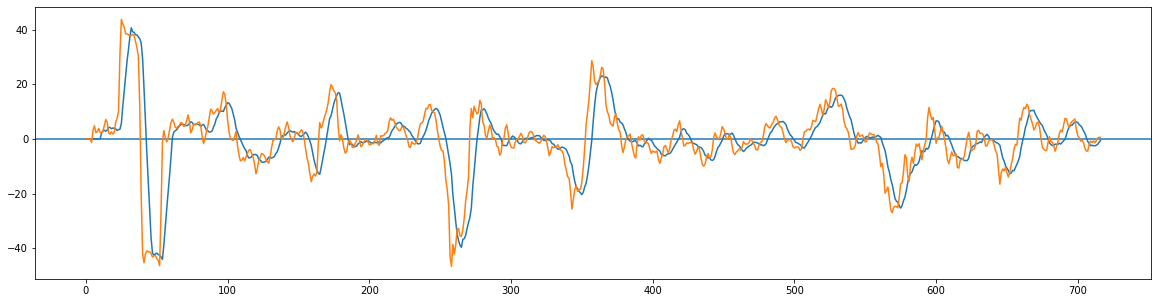

In [23]:
model.plot_lines(6);plt.show()
plt.figure(figsize=[20,5])
plt.axhline(0)
plot_pendiente(model, -10, -3)
plot_pendiente(model, -3, -1)

## HIPEROPT

In [34]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
import hyperopt

In [102]:
space = {
    'slope_long': hp.uniform('slope_long', -40, -10),
    'slope_short': hp.uniform('slope_short', -10, 10),
    'size_first_window': hp.choice('size_first_window', list(range(10, 21))),
    'gap_btw_windows': hp.choice('gap_btw_windows', list(range(0,10))),
    'size_second_window': hp.choice('size_second_window', list(range(2, 11)))
}

In [103]:
def objective(params):
    model = MA_Trader2(mode='sim',
                        period_long=25, 
                        period_short=14,
                     interval_group='1h', 
                     interval_source='1h',
                     panic= -0.04,
                     start_time=datetime.fromisoformat('2020-01-01'),
                     **params
                     )

    model.evaluate()

    return -model.score(1,1)

In [104]:
tpe_trials = Trials()

best = fmin(fn=objective,
            space=space,
            trials = tpe_trials,
            verbose=1,
            algo=hyperopt.tpe.suggest,
            return_argmin=False,
            max_evals=400)

100%|██████████| 400/400 [3:04:40<00:00, 27.70s/trial, best loss: -124.8737511589941]   


In [105]:
best.values()

dict_values([3, 12, 8, -10.34060671390852, 4.8560513825541145])

In [47]:
model2 = MA_Trader2(mode='sim',
                  period_long=25, 
                  period_short=14,
                 panic= -0.04,
                 interval_group='1h', 
                 interval_source='1h',
                 start_time=datetime.fromisoformat('2020-01-01'),
                 slope_long=-18.78,
                 slope_short=-8.33,
                 
                 )
model2.evaluate()
model2.score(1,1)

123.20210291452464

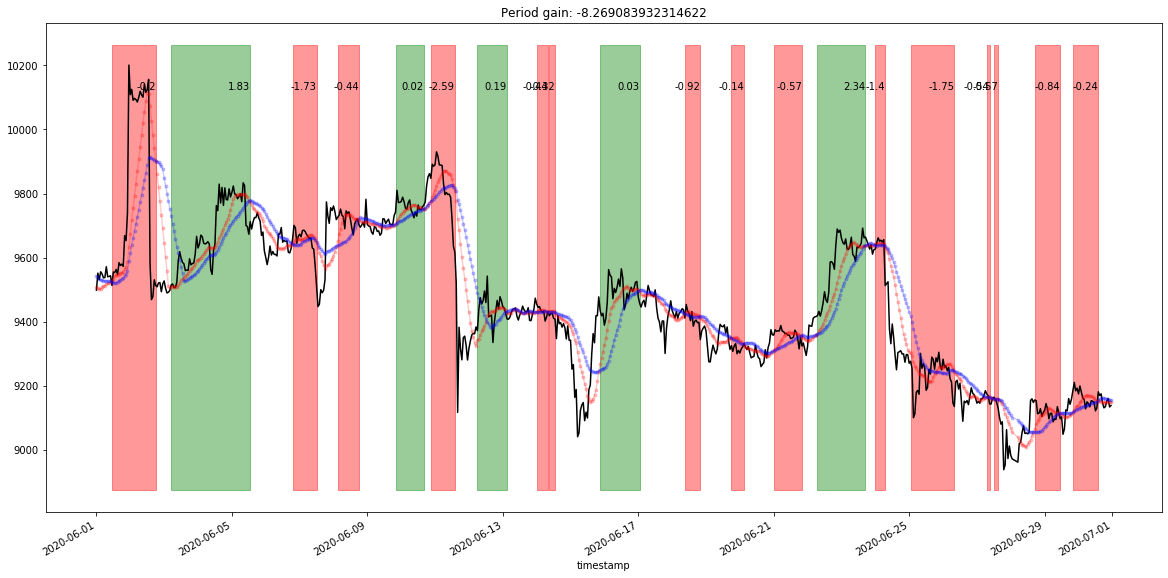

In [65]:
model2.plot_lines(6)

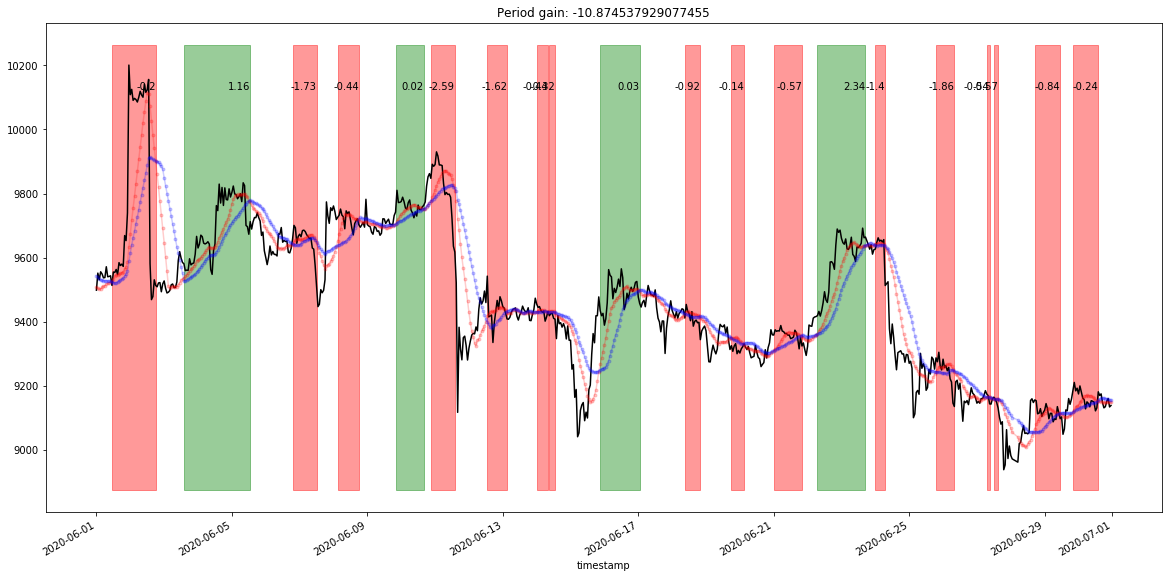

In [66]:
model.plot_lines(6)

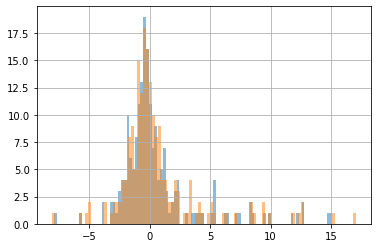

In [82]:
to_pandas(model.trade_record).gain.hist(bins=100, alpha=.5);
to_pandas(model2.trade_record).gain.hist(bins=100, alpha=0.5);

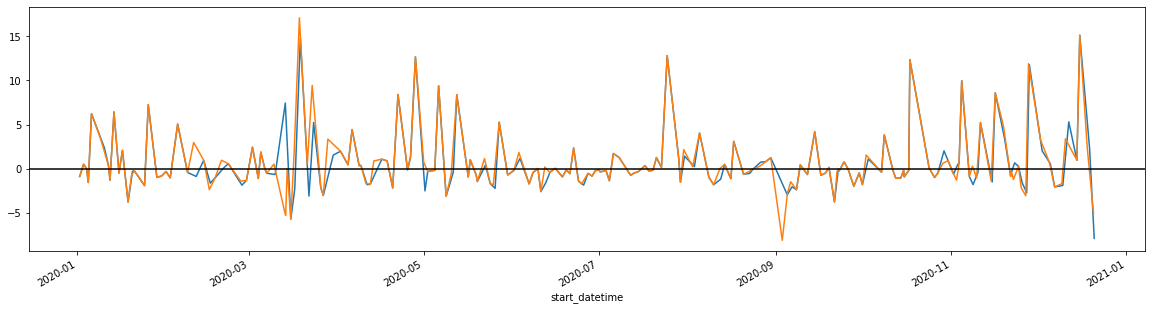

In [97]:
plt.figure(figsize=[20,5])
to_pandas(model.trade_record).set_index('start_datetime').gain.plot()
to_pandas(model2.trade_record).set_index('start_datetime').gain.plot()
plt.axhline(0, color='black')

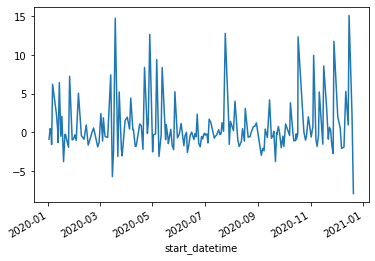

In [93]:
to_pandas(model.trade_record).set_index('start_datetime').gain.plot()